##Installations & Imports

In [62]:
!pip install pandas numpy matplotlib seaborn scikit-learn ipywidgets

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from ipywidgets import interact, widgets
from IPython.display import HTML, display

print("loaded")


loaded


##Loading Data

In [64]:
uploaded = files.upload()
df = pd.read_csv('food_wastage_data.csv')

Saving food_wastage_data.csv to food_wastage_data (1).csv


##Preprocessing

In [66]:
numeric_cols = ['NumGuests','QtyFood','Waste']
categorical_cols = ['FoodType','EventType','Storage','PurchaseHist','Season','PrepMethod','Location','Price']

In [67]:
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna('Unknown')


In [68]:
df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded['FoodPerGuest'] = df_encoded['QtyFood'] / df_encoded['NumGuests']

In [69]:
X = df_encoded.drop(['Waste'], axis=1)
y = df_encoded['Waste']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("ready for training")

ready for training


##Training Model

In [71]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("trained")

trained


##Metrics

In [72]:
def regression_metrics(y_true, y_pred, dataset_name='Dataset'):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Metrics:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

regression_metrics(y_train, rf_model.predict(X_train), 'Training')
regression_metrics(y_test, rf_model.predict(X_test), 'Testing')

Training Metrics:
MAE: 0.75, MSE: 1.91, RMSE: 1.38, R²: 0.98
Testing Metrics:
MAE: 1.62, MSE: 7.70, RMSE: 2.77, R²: 0.93


##Saving Model

In [73]:
import os
os.makedirs("models", exist_ok=True)
joblib.dump(rf_model, "models/restaurant_waste_model.pkl")
print("saved")


saved


##Prediction Function

In [74]:
def predict_waste(input_data):
    df_input = pd.DataFrame([input_data])
    df_input_encoded = pd.get_dummies(df_input, columns=categorical_cols)

    for col in X_train.columns:
        if col not in df_input_encoded.columns:
            df_input_encoded[col] = 0

    df_input_encoded = df_input_encoded[X_train.columns]
    df_input_encoded['FoodPerGuest'] = df_input_encoded['QtyFood'] / df_input_encoded['NumGuests']

    prediction = rf_model.predict(df_input_encoded)[0]
    return round(prediction, 2)


In [75]:
sample_input = {
    'FoodType': 'Vegetables',
    'NumGuests': 150,
    'EventType': 'Corporate',
    'QtyFood': 200,
    'Storage': 'Refrigerated',
    'PurchaseHist': 'Regular',
    'Season': 'Winter',
    'PrepMethod': 'Buffet',
    'Location': 'Urban',
    'Price': 'Moderate'
}
print("Sample Prediction:", predict_waste(sample_input))

Sample Prediction: 20.83


##Interface

In [76]:
def waste_level(waste):
    if waste < 20:
        return "Low", "green"
    elif waste < 40:
        return "Medium", "orange"
    else:
        return "High", "red"

In [77]:
def interactive_predict_visual(FoodType, NumGuests, EventType, QtyFood, Storage, PurchaseHist, Season, PrepMethod, Location, Price):
    input_data = {
        'FoodType': FoodType,
        'NumGuests': NumGuests,
        'EventType': EventType,
        'QtyFood': QtyFood,
        'Storage': Storage,
        'PurchaseHist': PurchaseHist,
        'Season': Season,
        'PrepMethod': PrepMethod,
        'Location': Location,
        'Price': Price
    }
    waste = predict_waste(input_data)
    level, color = waste_level(waste)
    display(HTML(f"<h3>Predicted Food Waste: <span style='color:{color}'>{waste} grams ({level})</span></h3>"))

In [78]:
interact(
    interactive_predict_visual,
    FoodType=widgets.Dropdown(options=df['FoodType'].unique().tolist(), value=df['FoodType'].iloc[0]),
    NumGuests=widgets.IntSlider(min=10, max=500, step=10, value=100),
    EventType=widgets.Dropdown(options=df['EventType'].unique().tolist(), value=df['EventType'].iloc[0]),
    QtyFood=widgets.IntSlider(min=50, max=1000, step=10, value=200),
    Storage=widgets.Dropdown(options=df['Storage'].unique().tolist(), value=df['Storage'].iloc[0]),
    PurchaseHist=widgets.Dropdown(options=df['PurchaseHist'].unique().tolist(), value=df['PurchaseHist'].iloc[0]),
    Season=widgets.Dropdown(options=df['Season'].unique().tolist(), value=df['Season'].iloc[0]),
    PrepMethod=widgets.Dropdown(options=df['PrepMethod'].unique().tolist(), value=df['PrepMethod'].iloc[0]),
    Location=widgets.Dropdown(options=df['Location'].unique().tolist(), value=df['Location'].iloc[0]),
    Price=widgets.Dropdown(options=df['Price'].unique().tolist(), value=df['Price'].iloc[0])
)

interactive(children=(Dropdown(description='FoodType', options=('Meat', 'Vegetables', 'Fruits', 'Baked Goods',…

<function __main__.interactive_predict_visual(FoodType, NumGuests, EventType, QtyFood, Storage, PurchaseHist, Season, PrepMethod, Location, Price)>

##Figures

*Distribution of Food Waste*

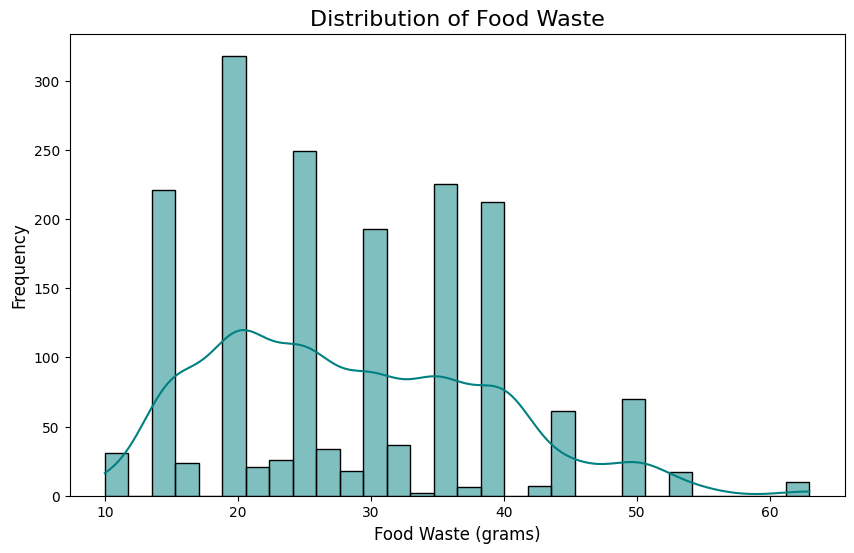

In [79]:
plt.figure(figsize=(10,6))
sns.histplot(df['Waste'], kde=True, bins=30, color='teal')
plt.title('Distribution of Food Waste', fontsize=16)
plt.xlabel('Food Waste (grams)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


*Feature Importance (Top 15)*

/tmp/ipython-input-2395352784.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


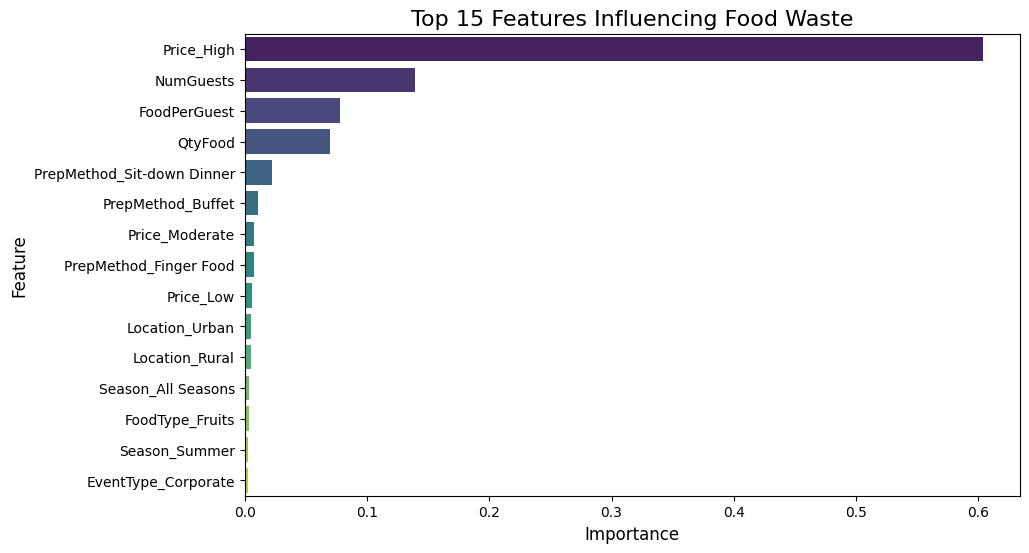

In [80]:
feat_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Top 15 Features Influencing Food Waste', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


*Actual vs Predicted Waste (Test Set)*

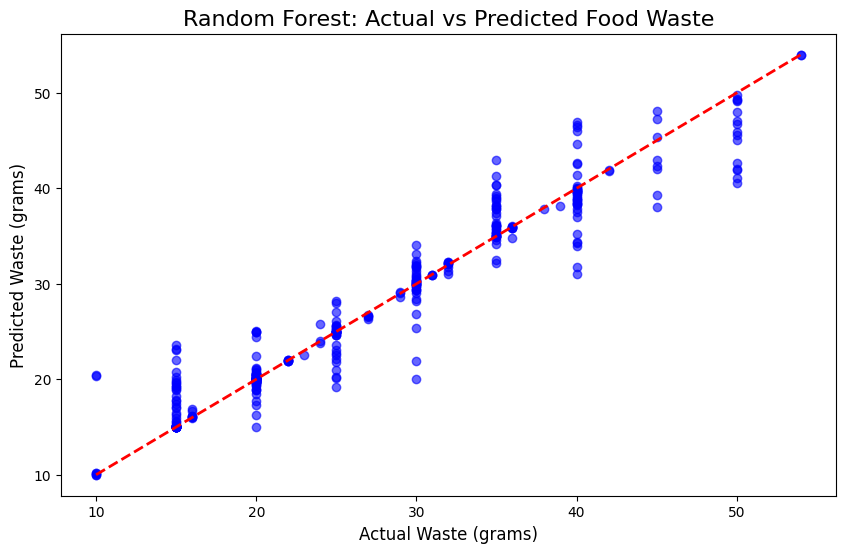

In [81]:
y_test_pred = rf_model.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Waste (grams)', fontsize=12)
plt.ylabel('Predicted Waste (grams)', fontsize=12)
plt.title('Random Forest: Actual vs Predicted Food Waste', fontsize=16)
plt.show()


*Residuals Distribution (Errors)*

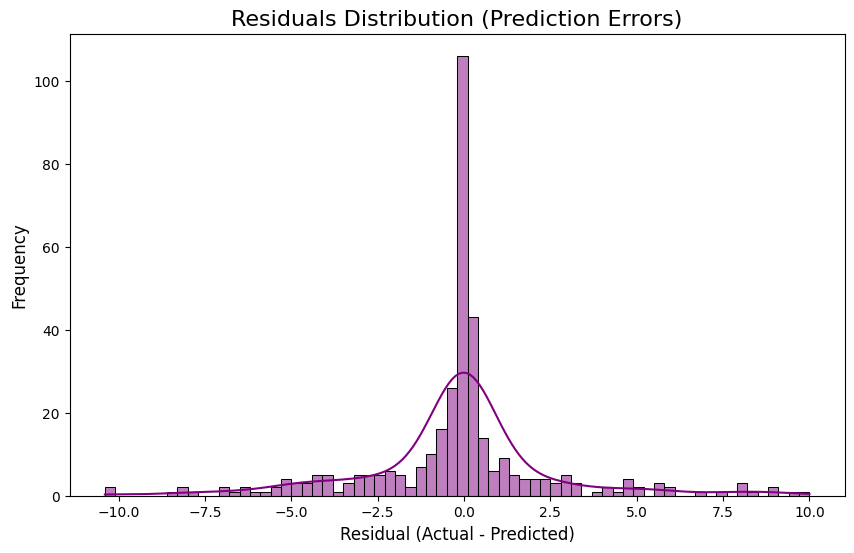

In [82]:
residuals = y_test - y_test_pred
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution (Prediction Errors)', fontsize=16)
plt.xlabel('Residual (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


*Average Waste per Guest by Food Type*

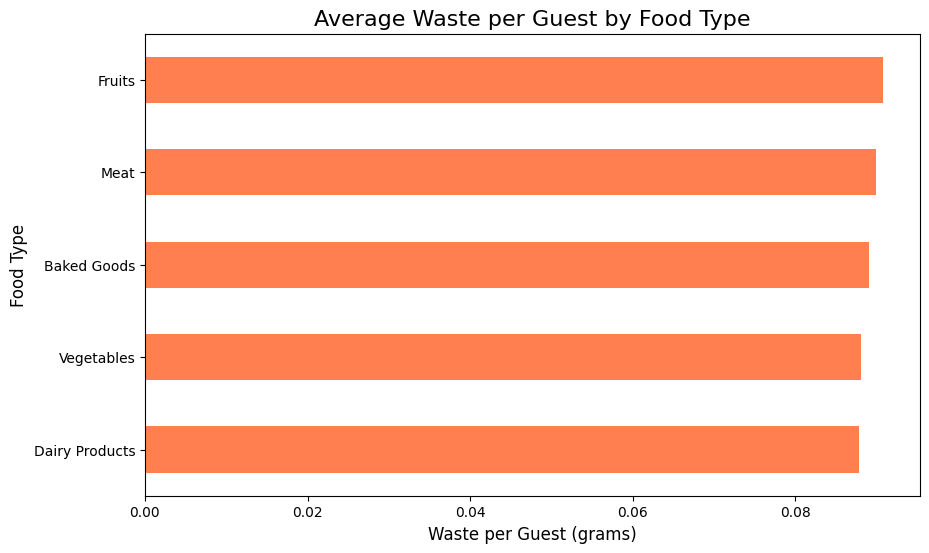

In [84]:
df['WastePerGuest'] = df['Waste'] / df['NumGuests']
avg_waste_foodtype = df.groupby('FoodType')['WastePerGuest'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_waste_foodtype.plot(kind='barh', color='coral')
plt.title('Average Waste per Guest by Food Type', fontsize=16)
plt.xlabel('Waste per Guest (grams)', fontsize=12)
plt.ylabel('Food Type', fontsize=12)
plt.show()


In [85]:
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/feature_importance.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

##GitHub Integration

In [87]:
!git config --global user.email "pragyaagarwal004@gmail.com"
!git config --global user.name "pragya-ag15"


In [88]:
!git clone https://github.com/pragya-ag15/FII-NX1Intl-PRAGYA-AGARWAL.git


Cloning into 'FII-NX1Intl-PRAGYA-AGARWAL'...


In [89]:
import shutil
import os


shutil.move('restaurant_food_waste_hackathon.ipynb', 'FII-NX1Intl-PRAGYA-AGARWAL/')
shutil.move('models/restaurant_waste_model.pkl', 'FII-NX1Intl-PRAGYA-AGARWAL/models/')
shutil.move('figures', 'FII-NX1Intl-PRAGYA-AGARWAL/')


FileNotFoundError: [Errno 2] No such file or directory: 'restaurant_food_waste_hackathon.ipynb'